# Image Segmentation with U-Net
Welcome !!
 We will be building Unet type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset.


Key points in this project:

* Build own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

In [32]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio.v2

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

Text(0.5, 1.0, 'segmentation')

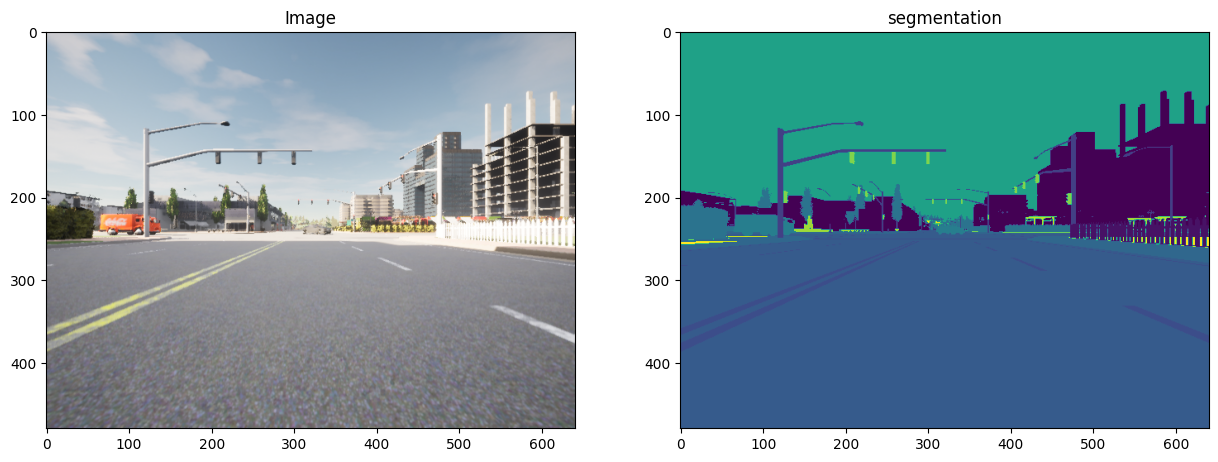

In [33]:
N = 2
img = imageio.v2.imread(image_list[N])
mask = imageio.v2.imread(mask_list[N])
fig, arr = plt.subplots(1,2, figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title("Image")
arr[1].imshow(mask[:,:,0])
arr[1].set_title("segmentation")

In [34]:
image_list_ds = tf.data.Dataset.list_files(image_list,shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle= False)
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
                print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [35]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/003856.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/003856.png', shape=(), dtype=string)


In [36]:
def process_path( image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask
def preprocess_image(image, mask):
    input_image = tf.image.resize(image, (96,128), method="nearest")
    input_mask = tf.image.resize(mask, (96,128), method="nearest")
    return input_image, input_mask
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess_image)
    

In [41]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0,max_pooling=True):

    conv = Conv2D(n_filters,
                  3,
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(inputs)
    conv = Conv2D(n_filters,3, activation="relu",padding="same",kernel_initializer="he_normal")(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
    skip_connection = conv
    return next_layer, skip_connection

In [42]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


In [47]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(n_filters,
                3,
                strides=2,
                padding="same",
                kernel_initializer="he_normal")(expansive_input)
    merge = concatenate([up, contractive_input],axis=3)
    conv = Conv2D(n_filters,3,activation="relu", padding="same",kernel_initializer="he_normal")(merge)
    conv = Conv2D(n_filters,3, activation="relu", padding="same", kernel_initializer="he_normal")(conv)

    return conv

In [48]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


In [72]:
def unet_model(input_size=(96,128,3),n_filters=32,n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs=inputs,n_filters=n_filters*1)
    cblock2 = conv_block(inputs= cblock1[0], n_filters = n_filters*2)
    cblock3 = conv_block(inputs = cblock2[0], n_filters = n_filters *4 )
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters * 8, dropout_prob=0.3 )
    cblock5 = conv_block(inputs = cblock4[0], n_filters = n_filters * 16, dropout_prob =0.3, max_pooling=False)
    ublock6 = upsampling_block (cblock5[0],cblock4[1],n_filters*8)
    ublock7 = upsampling_block(ublock6,cblock3[1], n_filters = n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters =n_filters *2 )
    ublock9 = upsampling_block (ublock8, cblock1[1], n_filters =n_filters)

    conv9 = Conv2D(n_filters,3, activation="relu", padding="same", kernel_initializer="he_normal")(ublock9)
    conv10 = Conv2D(n_classes,1,padding="same")(conv9)
    model = tf.keras.Model(inputs=inputs, outputs= conv10)

    return model

In [73]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


In [77]:
img_height = 96
img_widht = 128
img_channel = 3
unet = unet_model((img_height, img_widht,img_channel))


In [78]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 96, 128, 32)          896       ['input_19[0][0]']            
                                                                                                  
 conv2d_101 (Conv2D)         (None, 96, 128, 32)          9248      ['conv2d_100[0][0]']          
                                                                                                  
 max_pooling2d_22 (MaxPooli  (None, 48, 64, 32)           0         ['conv2d_101[0][0]']          
 ng2D)                                                                                      

In [80]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title =["Input Image", "True Mask", "Predicted Mask"]
    for i in range (len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis("off")
    plt.show()

(480, 640, 1)


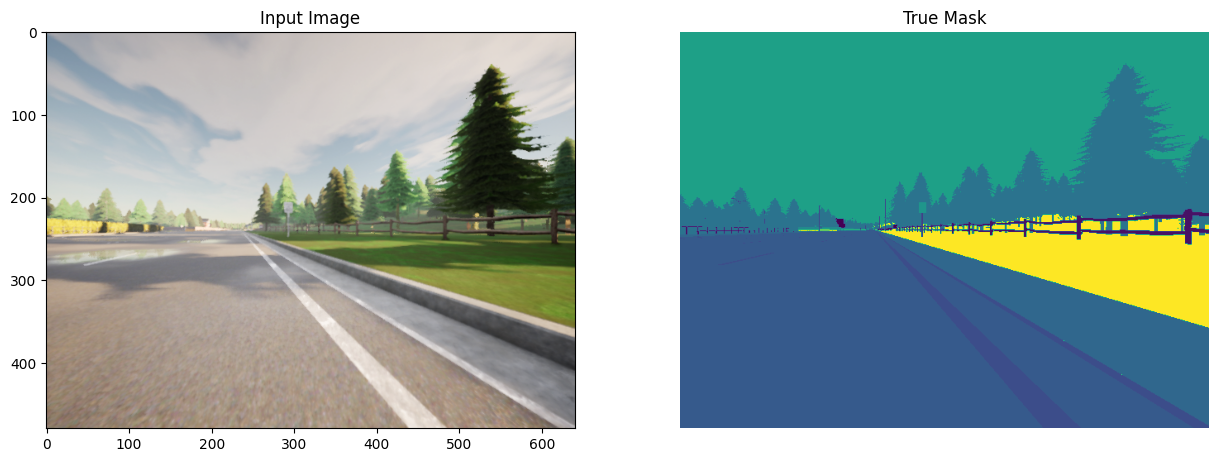

In [90]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


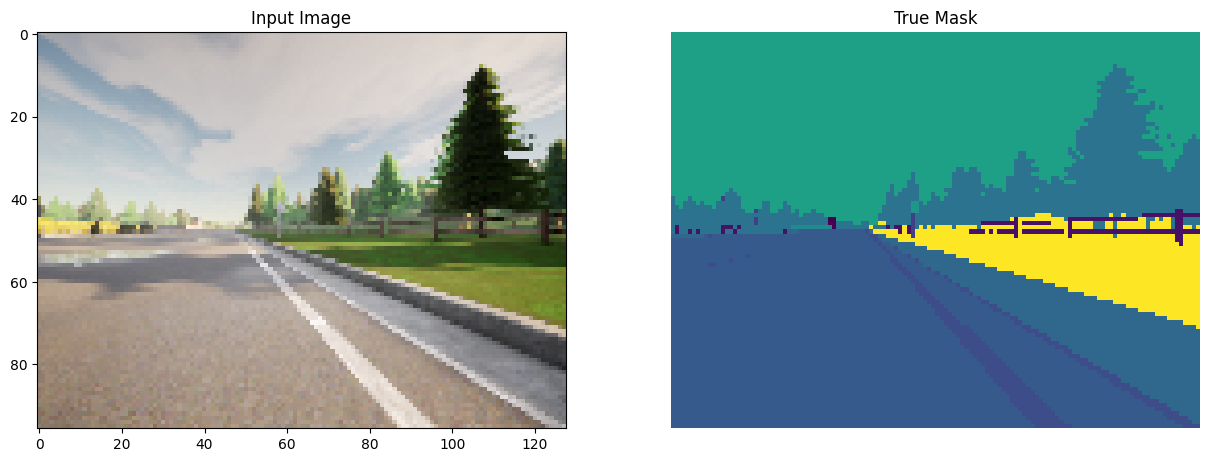

In [91]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [92]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 99s 3s/step - loss: 1.9697 - accuracy: 0.4979
Epoch 2/5
34/34 [==============================] - 95s 3s/step - loss: 0.8780 - accuracy: 0.7720
Epoch 3/5
34/34 [==============================] - 94s 3s/step - loss: 0.5924 - accuracy: 0.8207
Epoch 4/5
34/34 [==============================] - 94s 3s/step - loss: 0.4914 - accuracy: 0.8497
Epoch 5/5
34/34 [==============================] - 95s 3s/step - loss: 0.4191 - accuracy: 0.8729


In [93]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

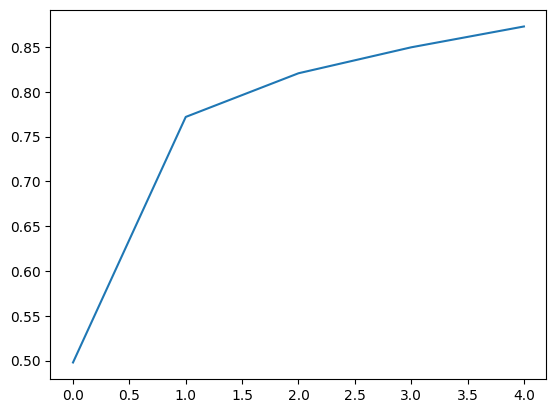

In [94]:
plt.plot(model_history.history["accuracy"])

In [95]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 797ms/step


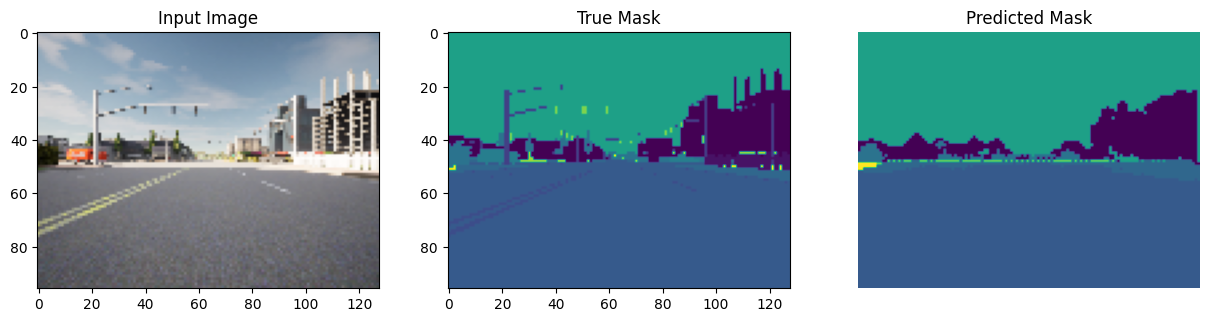

1/1 [==============================] - 1s 616ms/step


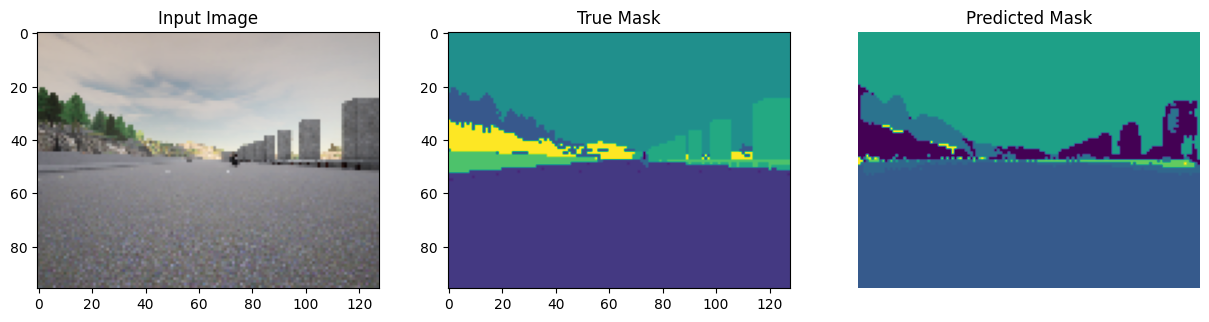

1/1 [==============================] - 1s 608ms/step


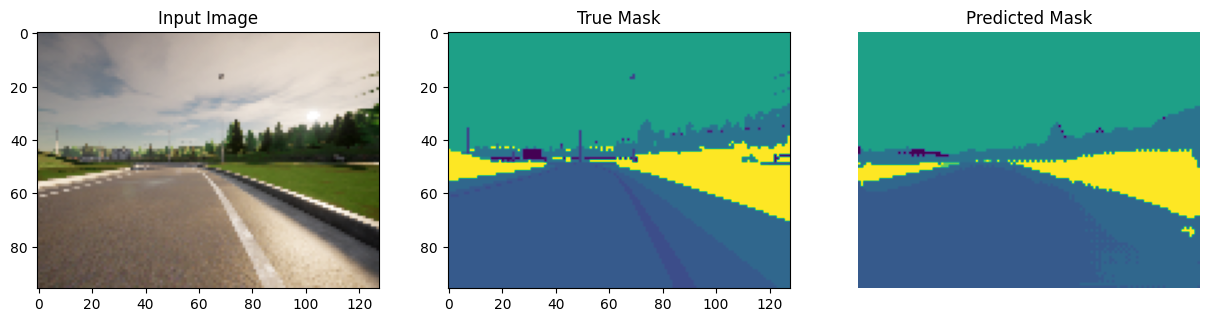

1/1 [==============================] - 1s 606ms/step


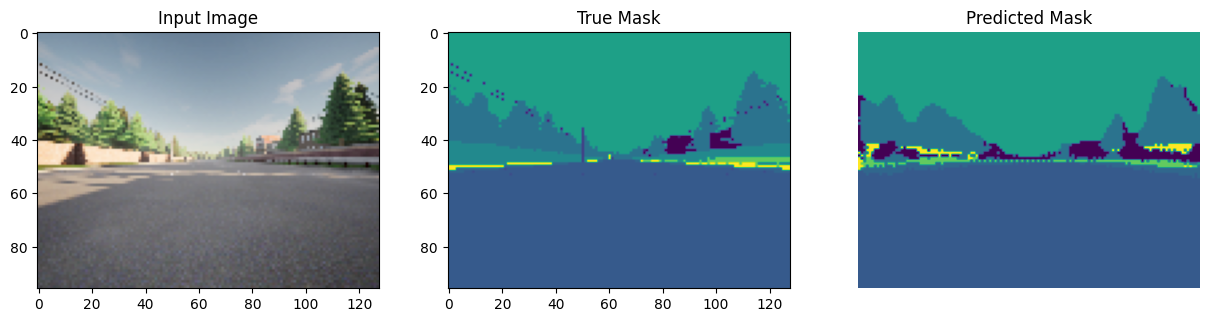

1/1 [==============================] - 1s 620ms/step


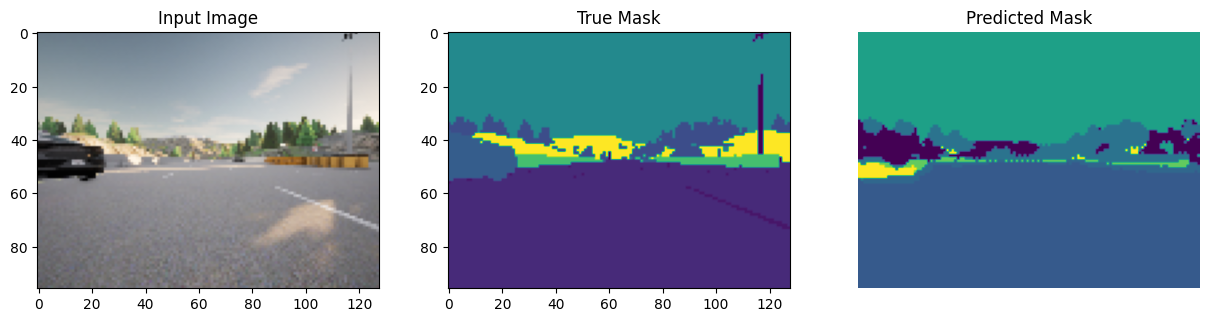

1/1 [==============================] - 1s 610ms/step


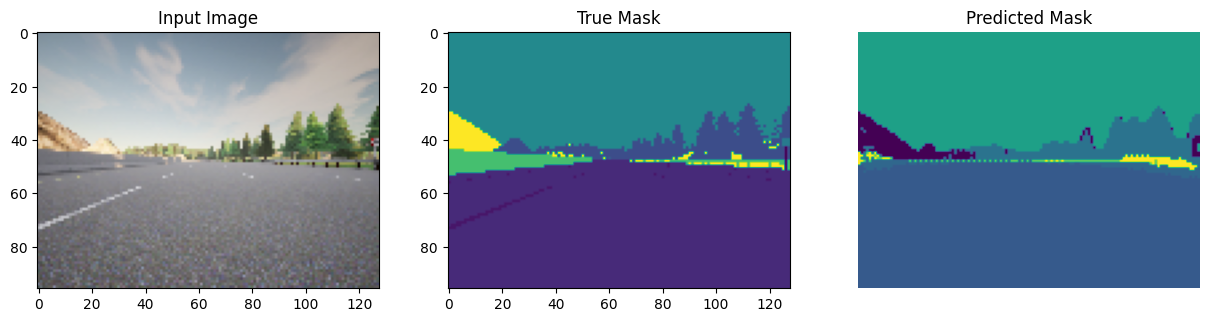

In [96]:
show_predictions(train_dataset, 6)